# Install detectron2

In [1]:
# Install detectron2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import detectron2
print(torch.__version__)

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions

/home/chia/anaconda3/envs/py36/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.8.0+cu111
torch:  1.8 ; cuda:  cu111


# Install Mask2Former

In [11]:
# clone and install Mask2Former
!git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
!pip install -U opencv-python
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

Cloning into 'Mask2Former'...
remote: Enumerating objects: 297, done.
remote: Total 297 (delta 0), reused 0 (delta 0), pack-reused 297
Receiving objects: 100% (297/297), 410.94 KiB | 7.34 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/media/data_16T/chloe/try/Mask2Former/Mask2Former
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-4sel852j
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-4sel852j
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
/media/data_16T/chloe/try/Mask2Former/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
creating build
creating build/lib.linux-x86_64-cpython-37
creating build/lib.linux-x86_64-cpython-37/functions
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-cpython-37/functions
copying functions/__in

In [12]:
%cd Mask2Former

[Errno 2] No such file or directory: 'Mask2Former'
/media/data_16T/chloe/try/Mask2Former/Mask2Former


In [13]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
%ls
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")

# import some common libraries
import numpy as np
import cv2
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

ADVANCED_USAGE.md   LICENSE       datasets/           predict.py
CODE_OF_CONDUCT.md  MODEL_ZOO.md  demo/               requirements.txt
CONTRIBUTING.md     README.md     demo_video/         tools/
GETTING_STARTED.md  cog.yaml      mask2former/        train_net.py
INSTALL.md          configs/      mask2former_video/  train_net_video.py


# Run a pre-trained Mask2Former model

We first download an image from the COCO dataset:

In [14]:
# !wget http://images.cocodataset.org/val2017/000000005477.jpg -q -O input.jpg
im = cv2.imread("/media/data_16T/chloe/999.png")
# plt.imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [15]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("configs/coco/panoptic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_100ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_f07440.pkl'
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True

device = torch.device('cuda')
predictor = DefaultPredictor(cfg)

WARNING [06/12 20:33:49 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [16]:
import torch
print(torch.cuda.get_device_properties(0))
print(torch.cuda.get_device_capability(0))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
(7, 5)


In [17]:
outputs = predictor(im)

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


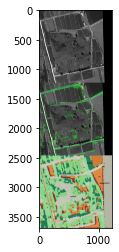

In [31]:
# Show panoptic/instance/semantic predictions: 
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
panoptic_result = v.draw_panoptic_seg(outputs["panoptic_seg"][0].to("cpu"), outputs["panoptic_seg"][1]).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
plt.imshow(np.concatenate((panoptic_result, instance_result, semantic_result), axis=0)[:, :, ::-1])

In [25]:
plt.savefig('temp.png')


<Figure size 432x288 with 0 Axes>

In [28]:
from PIL import Image
import requests
import shutil


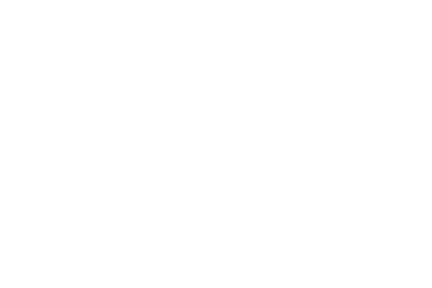

In [30]:
image = Image.open('temp.png')
image

In [23]:
plt.savefig('/media/data_16T/chloe/try/output_semseg')

<Figure size 432x288 with 0 Axes>

Let's try an image not from COCO as well:

In [9]:
# Download a sample image and display. Replace path here to try your own images!
# !wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
im = cv2.imread("../../999.png")
#plt.imshow(im)

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


ValueError: array([[[ 38,  38,  38],
        [ 35,  35,  35],
        [ 37,  37,  37],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 39,  39,  39],
        [ 34,  34,  34],
        [ 38,  38,  38],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 39,  39,  39],
        [ 34,  34,  34],
        [ 38,  38,  38],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[190, 193, 179],
        [191, 192, 178],
        [190, 192, 177],
        ...,
        [203, 114,  47],
        [203, 114,  47],
        [203, 114,  47]],

       [[192, 193, 178],
        [192, 193, 179],
        [192, 194, 179],
        ...,
        [203, 114,  47],
        [203, 114,  47],
        [203, 114,  47]],

       [[194, 194, 180],
        [194, 195, 180],
        [194, 195, 181],
        ...,
        [203, 114,  47],
        [203, 114,  47],
        [203, 114,  47]]], dtype=uint8) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

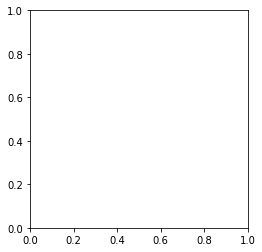

In [22]:
outputs = predictor(im)
# Show panoptic/instance/semantic predictions: 
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
panoptic_result = v.draw_panoptic_seg(outputs["panoptic_seg"][0].to("cpu"), outputs["panoptic_seg"][1]).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
plt.imshow("Output", np.concatenate((panoptic_result, instance_result, semantic_result), axis=0)[:, :, ::-1])


In [ ]:
plt.savefig('/path/to/save/image.png')